In [1]:
from jax.config import config

config.update("jax_enable_x64", True)

import jax
from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook, Float, Int
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import optax as ox
import tensorflow_probability.substrates.jax as tfp
from typing import List, Tuple

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
from gpjax.bayes_opt.function_evaluator import build_function_evaluator, OBJECTIVE
from gpjax.bayes_opt.search_space import BoxSearchSpace
from gpjax.bayes_opt.bayesian_optimiser import BayesianOptimiser
from gpjax.bayes_opt.posterior_optimiser import AdamPosteriorOptimiser
from gpjax.bayes_opt.acquisition_functions import (
    ThompsonSamplingAcquisitionFunctionBuilder,
)
from gpjax.bayes_opt.acquisition_optimiser import ContinuousAcquisitionOptimiser
from gpjax.typing import Array, Float

key = jr.PRNGKey(42)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]


In [2]:
def forrester(x: Float[Array, "N 1"]) -> Float[Array, "N 1"]:
    return (6 * x - 2) ** 2 * jnp.sin(12 * x - 4)

In [3]:
# Define a function to print the most recently queried point after the "ask" step
def print_most_recent_query(
    bo: BayesianOptimiser, last_queried_point: Float[Array, "1 D"]
):
    print(f"Most recently queried point: {last_queried_point}")


In [4]:
# Define a function to plot the most recently queried point after the "ask" step, along
# with the acquisition function and the predictive posterior for debugging purposes
def plot_bo_iteration(bo: BayesianOptimiser, last_queried_point: Float[Array, "1 D"]):
    posterior = bo.posteriors[OBJECTIVE]
    dataset = bo.datasets[OBJECTIVE]
    plt_x = jnp.linspace(0, 1, 1000).reshape(-1, 1)
    forrester_y = forrester(plt_x)
    acquisition_fn = bo.acquisition_function_builder.build_acquisition_function(
        bo.posteriors, bo.datasets, bo.key
    )
    sample_y = - acquisition_fn(plt_x)

    latent_dist = posterior.predict(plt_x, train_data=dataset)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    fig, ax = plt.subplots()
    ax.plot(plt_x, predictive_mean, label="Predictive Mean", color=cols[1])
    ax.fill_between(
        plt_x.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        plt_x,
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        plt_x,
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(plt_x, sample_y, label="Posterior Sample")
    ax.plot(
        plt_x,
        forrester_y,
        label="Forrester Function",
        color=cols[0],
        linestyle="--",
        linewidth=2,
    )
    ax.axvline(x=0.757, linestyle=":", color=cols[3], label="True Optimum")
    ax.scatter(dataset.X, dataset.y, label="Observations", color=cols[2], zorder=2)
    ax.scatter(
        last_queried_point,
        -acquisition_fn(last_queried_point),
        label="Posterior Sample Optimum",
        marker="*",
        color=cols[3],
        zorder=3,
    )
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    plt.show()

Lower Bounds Shape: (1,)


/Users/thomaschristie/Documents/GitHub.nosync/GPJax/venv/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3613: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


Initial x: [[0.10147952]
 [0.85147953]
 [0.35147953]
 [0.72647953]
 [0.22647952]]
Inital Datasets: {'OBJECTIVE': - Number of observations: 5
- Input dimension: 1
- Output dimension: 1}
Posterior: ConjugatePosterior(prior=Prior(kernel=Matern52(compute_engine=DenseKernelComputation(), active_dims=None, name='Matérn52', lengthscale=Array(1., dtype=float64, weak_type=True), variance=Array(1., dtype=float64, weak_type=True)), mean_function=Constant(constant=Array([0.], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=5, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(1.e-06, dtype=float64, weak_type=True)), jitter=1e-06)
Starting Iteration 0
Initial Sample Values Shape: (100, 1) Should be [N, 1]
Best Initial Sample Point Shape: (1, 1) Should be [1, D]
Optimised Point Shape: (1, 1) Should be [1, D]
Most recently queried point: [[0.63691595]]


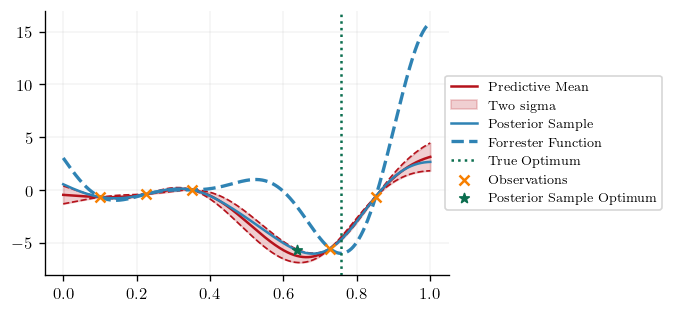

Posterior: ConjugatePosterior(prior=Prior(kernel=Matern52(compute_engine=DenseKernelComputation(), active_dims=None, name='Matérn52', lengthscale=Array(0.29805053, dtype=float64), variance=Array(2.0685075, dtype=float64)), mean_function=Constant(constant=Array([0.30230135], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=5, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(1.e-06, dtype=float64)), jitter=1e-06)
Starting Iteration 1
Initial Sample Values Shape: (100, 1) Should be [N, 1]
Best Initial Sample Point Shape: (1, 1) Should be [1, D]
Optimised Point Shape: (1, 1) Should be [1, D]
Most recently queried point: [[0.71038611]]


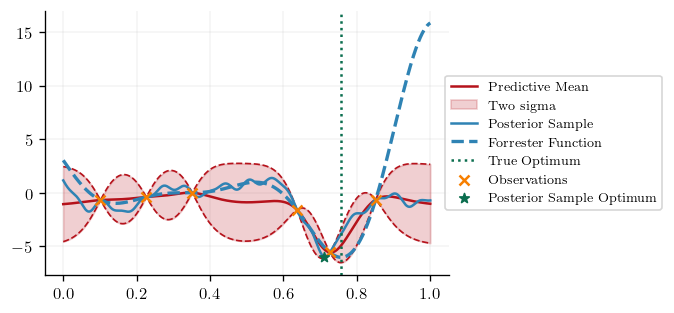

Posterior: ConjugatePosterior(prior=Prior(kernel=Matern52(compute_engine=DenseKernelComputation(), active_dims=None, name='Matérn52', lengthscale=Array(0.07324714, dtype=float64), variance=Array(3.44124059, dtype=float64)), mean_function=Constant(constant=Array([-1.20656299], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=5, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(1.e-06, dtype=float64)), jitter=1e-06)
Starting Iteration 2
Initial Sample Values Shape: (100, 1) Should be [N, 1]
Best Initial Sample Point Shape: (1, 1) Should be [1, D]
Optimised Point Shape: (1, 1) Should be [1, D]
Most recently queried point: [[0.73174462]]


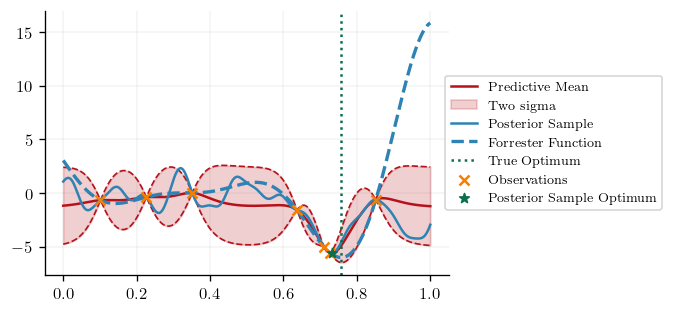

Posterior: ConjugatePosterior(prior=Prior(kernel=Matern52(compute_engine=DenseKernelComputation(), active_dims=None, name='Matérn52', lengthscale=Array(0.05935332, dtype=float64), variance=Array(3.35623358, dtype=float64)), mean_function=Constant(constant=Array([-1.31285898], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=5, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(1.e-06, dtype=float64)), jitter=1e-06)
Starting Iteration 3
Initial Sample Values Shape: (100, 1) Should be [N, 1]
Best Initial Sample Point Shape: (1, 1) Should be [1, D]
Optimised Point Shape: (1, 1) Should be [1, D]
Most recently queried point: [[0.74862461]]


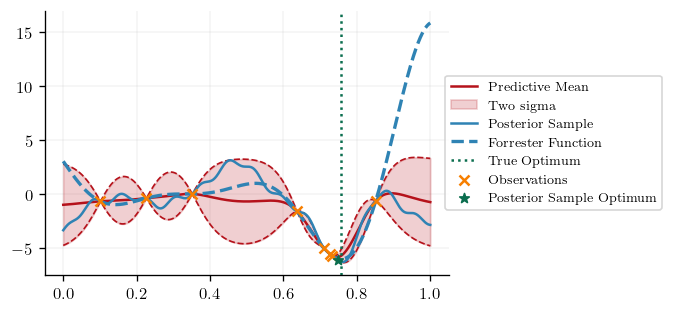

Posterior: ConjugatePosterior(prior=Prior(kernel=Matern52(compute_engine=DenseKernelComputation(), active_dims=None, name='Matérn52', lengthscale=Array(0.08345513, dtype=float64), variance=Array(4.26627429, dtype=float64)), mean_function=Constant(constant=Array([-1.1625627], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=5, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(1.e-06, dtype=float64)), jitter=1e-06)
Starting Iteration 4
Initial Sample Values Shape: (100, 1) Should be [N, 1]
Best Initial Sample Point Shape: (1, 1) Should be [1, D]
Optimised Point Shape: (1, 1) Should be [1, D]
Most recently queried point: [[0.75336767]]


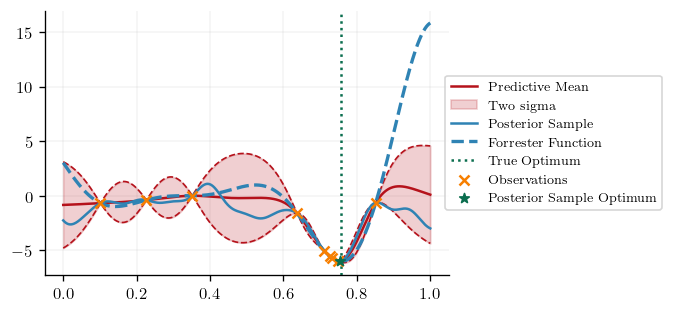

Posterior: ConjugatePosterior(prior=Prior(kernel=Matern52(compute_engine=DenseKernelComputation(), active_dims=None, name='Matérn52', lengthscale=Array(0.1044999, dtype=float64), variance=Array(5.66706938, dtype=float64)), mean_function=Constant(constant=Array([-0.94719356], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=5, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(1.e-06, dtype=float64)), jitter=1e-06)
Starting Iteration 5
Initial Sample Values Shape: (100, 1) Should be [N, 1]
Best Initial Sample Point Shape: (1, 1) Should be [1, D]
Optimised Point Shape: (1, 1) Should be [1, D]
Most recently queried point: [[0.75632814]]


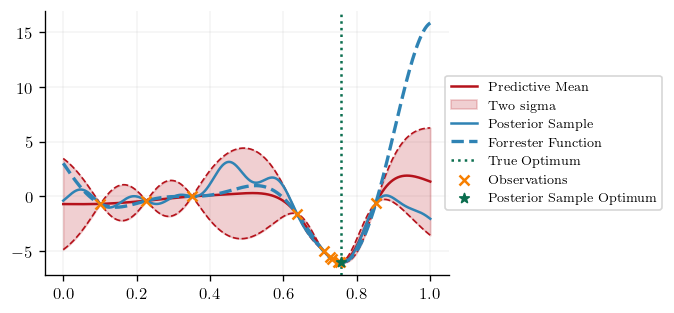

Posterior: ConjugatePosterior(prior=Prior(kernel=Matern52(compute_engine=DenseKernelComputation(), active_dims=None, name='Matérn52', lengthscale=Array(0.12764358, dtype=float64), variance=Array(7.94910668, dtype=float64)), mean_function=Constant(constant=Array([-0.6384824], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=5, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(1.e-06, dtype=float64)), jitter=1e-06)
Starting Iteration 6
Initial Sample Values Shape: (100, 1) Should be [N, 1]
Best Initial Sample Point Shape: (1, 1) Should be [1, D]
Optimised Point Shape: (1, 1) Should be [1, D]
Most recently queried point: [[0.75748773]]


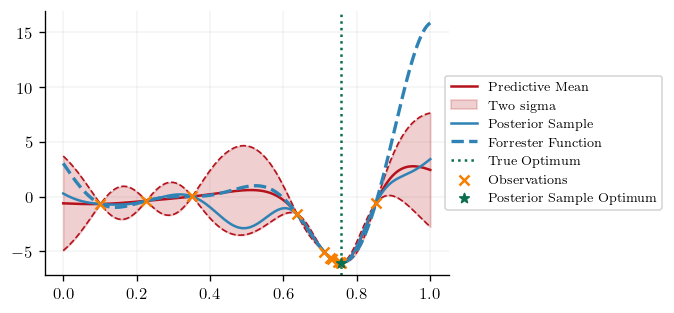

Posterior: ConjugatePosterior(prior=Prior(kernel=Matern52(compute_engine=DenseKernelComputation(), active_dims=None, name='Matérn52', lengthscale=Array(0.14574688, dtype=float64), variance=Array(10.3919058, dtype=float64)), mean_function=Constant(constant=Array([-0.37395104], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=5, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(1.e-06, dtype=float64)), jitter=1e-06)
Starting Iteration 7
Initial Sample Values Shape: (100, 1) Should be [N, 1]
Best Initial Sample Point Shape: (1, 1) Should be [1, D]
Optimised Point Shape: (1, 1) Should be [1, D]
Most recently queried point: [[0.7571262]]


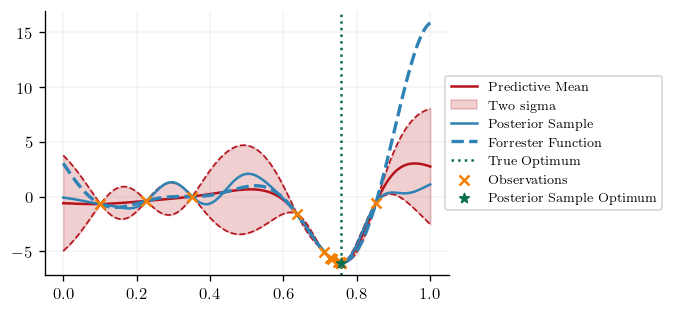

Posterior: ConjugatePosterior(prior=Prior(kernel=Matern52(compute_engine=DenseKernelComputation(), active_dims=None, name='Matérn52', lengthscale=Array(0.15072855, dtype=float64), variance=Array(11.21295299, dtype=float64)), mean_function=Constant(constant=Array([-0.294963], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=5, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(1.e-06, dtype=float64)), jitter=1e-06)
Starting Iteration 8
Initial Sample Values Shape: (100, 1) Should be [N, 1]
Best Initial Sample Point Shape: (1, 1) Should be [1, D]
Optimised Point Shape: (1, 1) Should be [1, D]
Most recently queried point: [[0.75658157]]


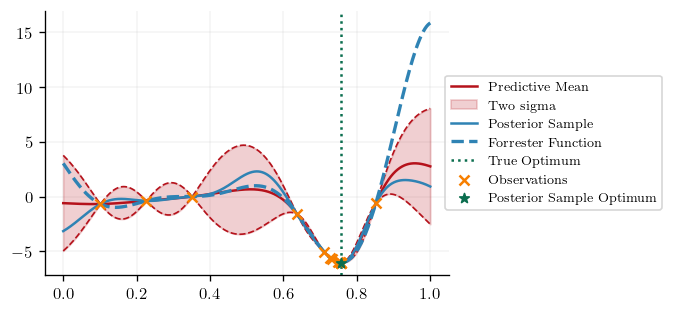

Posterior: ConjugatePosterior(prior=Prior(kernel=Matern52(compute_engine=DenseKernelComputation(), active_dims=None, name='Matérn52', lengthscale=Array(0.15092342, dtype=float64), variance=Array(11.24643298, dtype=float64)), mean_function=Constant(constant=Array([-0.29183322], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=5, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(1.e-06, dtype=float64)), jitter=1e-06)
Starting Iteration 9
Initial Sample Values Shape: (100, 1) Should be [N, 1]
Best Initial Sample Point Shape: (1, 1) Should be [1, D]
Optimised Point Shape: (1, 1) Should be [1, D]
Most recently queried point: [[0.75746316]]


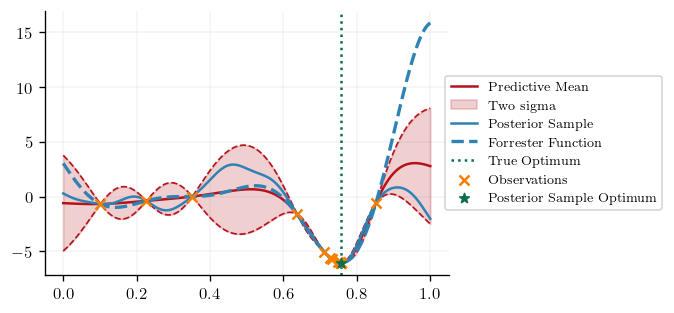

Posterior: ConjugatePosterior(prior=Prior(kernel=Matern52(compute_engine=DenseKernelComputation(), active_dims=None, name='Matérn52', lengthscale=Array(0.15129668, dtype=float64), variance=Array(11.30667746, dtype=float64)), mean_function=Constant(constant=Array([-0.28618039], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=5, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(1.e-06, dtype=float64)), jitter=1e-06)
Queried x values: [[0.10147952]
 [0.85147953]
 [0.35147953]
 [0.72647953]
 [0.22647952]
 [0.63691595]
 [0.71038611]
 [0.73174462]
 [0.74862461]
 [0.75336767]
 [0.75632814]
 [0.75748773]
 [0.7571262 ]
 [0.75658157]
 [0.75746316]]
Queried y values: [[-6.80546048e-01]
 [-6.31946602e-01]
 [ 2.56096130e-03]
 [-5.56422147e+00]
 [-3.94045159e-01]
 [-1.59473144e+00]
 [-5.02812973e+00]
 [-5.70091636e+00]
 [-5.98203102e+00]
 [-6.01278674e+00]
 [-6.02028866e+00]
 [-6.02070954e+00]
 [-6.02073204e+00]
 [-6.02050280e+00]
 [-6.02071549e+00]]


In [5]:
function_evaluator = build_function_evaluator({OBJECTIVE: forrester})
lower_bounds = jnp.array([0.0])
upper_bounds = jnp.array([1.0])
print(f"Lower Bounds Shape: {lower_bounds.shape}")
search_space = BoxSearchSpace(lower_bounds=lower_bounds, upper_bounds=upper_bounds)
initial_x = search_space.sample_halton(5, key)
print(f"Initial x: {initial_x}")
initial_datasets = function_evaluator(initial_x)
print(f"Inital Datasets: {initial_datasets}")

mean = gpx.mean_functions.Zero()
kernel = gpx.kernels.Matern52()
prior = gpx.Prior(mean_function=mean, kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=5, obs_noise=jnp.array(1e-6))  # TODO: This is hacky, need to sort out the `num_datapoints` argument for likelihoods...
likelihood = likelihood.replace_trainable(obs_noise=False)
posterior = prior * likelihood
posteriors = {OBJECTIVE: posterior}
posterior_optimiser = AdamPosteriorOptimiser(
    num_iters=1000,
    learning_rate=0.01,
    objective=gpx.objectives.ConjugateMLL(negative=True),
)
acquisition_function_builder = ThompsonSamplingAcquisitionFunctionBuilder(
    num_rff_features=500
)
acquisition_optimiser = ContinuousAcquisitionOptimiser(num_initial_samples=100)
bo = BayesianOptimiser(
    search_space=search_space,
    posteriors=posteriors,
    datasets=initial_datasets,
    posterior_optimiser=posterior_optimiser,
    acquisition_function_builder=acquisition_function_builder,
    acquisition_optimiser=acquisition_optimiser,
    key=key,
    black_box_function_evaluator=function_evaluator,
    post_ask=[print_most_recent_query, plot_bo_iteration],
)

results = bo.run(10)
print(f"Queried x values: {results[OBJECTIVE].X}")
print(f"Queried y values: {results[OBJECTIVE].y}")